# Análisis exploratorio de los datos simulados

En este notebook analizamos los 200 puntos aleatorios en la cdmx. 

Nuestro interés se centra en conocer patrones interesantes y problemas que se presentan con los datos georeferenciado. 

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd 
from shapely.geometry import Point
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import folium
import random

In [22]:
def str_zeros(s,n):
    '''
    Toma el string s y le anexa ceros a la izquierda. 
    El largo del string al final debe ser n. 
    '''
    z = str(s)
    m = len(z)
    if m==n:
        return z
    else: 
        for i in range(n-m):
            z = '0'+z 
        return z

def cvegeo(row):
    '''
    Toma una fila (del censo) y obtiene el CVEGEO de la manzana. 
    Si la manzana en cero, lo cual representa un total del ageb, 
        se le asigna código nan. 
    '''
    entidad = str(row['entidad'])
    municipio = str(row['mun'])
    localidad = str(row['loc'])
    ageb = str(row['ageb'])
    mza = str(row['mza'])

    entidad = str_zeros(entidad,2)
    municipio = str_zeros(municipio,3)
    localidad = str_zeros(localidad,4)
    ageb = str_zeros(ageb,4)
    mza = str_zeros(mza,3)
  
    if mza=='000':
        cve_geo = np.nan
    else:
        cve_geo = entidad+municipio+localidad+ageb+mza
  
    return cve_geo

['#C89A94', '#AE7ED9', '#6009F6', '#207C14', '#50D8F6', '#1FAA07', '#C4EEC7', '#678924']


Cargamos la base muestra con el shapefile de la entidad 

Cambiamos el sietema de coordenadas para que coincidan

In [3]:
data = pd.read_csv('casas_sample_cdmx.csv')
shp_ent = gpd.read_file('/home/alain/Desktop/Proyectos_PonderaLab/datos/shapefiles/estados/9/09ent.shp')
shp_ent = shp_ent.to_crs("EPSG:4326")
pts = [Point(lon,lat) for lon,lat in zip(data['longitud'],data['latitud'])]
points = gpd.GeoDataFrame({'geometry':pts})
points = points.set_crs("EPSG:4326")

Graficamos los puntos en la entidad

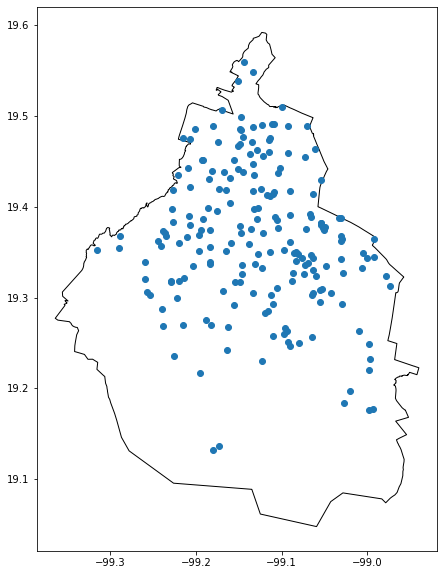

In [4]:
base = shp_ent.plot(color='white', edgecolor='black',figsize=[10,10])
points.plot(ax=base)

Cargamos el censo y se lo pegamos a la base

In [5]:
censo = pd.read_csv('/home/alain/Desktop/Proyectos_PonderaLab/datos/censo_2010/resultados_ageb_urbana_09_cpv2010.csv')
censo['CVEGEO'] = censo[['entidad','mun','loc','ageb','mza']].apply(cvegeo,axis=1)
censo = censo.replace('*',np.nan)
censo = censo.replace('N/D',np.nan)

In [6]:
data = data.merge(censo,left_on='CVEGEO',right_on='CVEGEO')

Seleccionamos un número determinado de columnas

In [7]:
# columnas = ['CVEGEO', 'latitud', 'longitud', 'bancos_numero', 'bancos_distancia',
#             'secundarias_privadas_distancia','supermercados_numero', 'supermercados_distancia',
#             'hospitales_privados_distancia', 'cines_distancia', 'restaurantes_numero','restaurantes_distancia', 
#             'cafeterias_numero', 'cafeterias_distancia','hoteles_distancia']
columnas = ['CVEGEO', 'latitud', 'longitud', 'bancos_numero', 'bancos_distancia',
            'secundarias_privadas_distancia','supermercados_numero', 'supermercados_distancia',
            'hospitales_privados_distancia', 'cines_distancia', 'restaurantes_numero','restaurantes_distancia', 
            'cafeterias_distancia','hoteles_distancia','pobtot','hogjef_f','tothog','pob65_mas','pocupada']
data_subset = data[columnas].copy()
data_subset = data_subset.dropna()

In [8]:
for c in ['pobtot','hogjef_f','tothog','pob65_mas','pocupada']: 
    data_subset[c] = data_subset[c].astype(float)

for c in ['bancos_numero', 'bancos_distancia',
            'secundarias_privadas_distancia','supermercados_numero', 'supermercados_distancia',
            'hospitales_privados_distancia', 'cines_distancia', 'restaurantes_numero','restaurantes_distancia', 
            'cafeterias_distancia','hoteles_distancia']:
    data_subset[c] = np.log(data_subset[c]+1)

In [9]:
#sns.pairplot(data_subset.iloc[:,3:k])

Proporción cluster #2D7B9F
48.05
Proporción cluster #A2AE9A
11.04
Proporción cluster #D2214E
6.49
Proporción cluster #FA4F3C
7.14
Proporción cluster #0365FA
1.3
Proporción cluster #F51CEB
2.6
Proporción cluster #ADDC38
1.3
Proporción cluster #584C25
0.65
Proporción cluster #14C2E2
0.65
Proporción cluster #6441DE
0.65
Proporción cluster #91E1B0
0.65
Proporción cluster #589F14
0.65
Proporción cluster #299339
0.65
Proporción cluster #19C78D
1.3
Proporción cluster #C71831
1.3
Proporción cluster #404718
0.65
Proporción cluster #4C19BB
1.3
Proporción cluster #13B9F1
0.65
Proporción cluster #ED2648
0.65
Proporción cluster #58034A
0.65
Proporción cluster #F60C60
1.3
Proporción cluster #8D2640
1.95
Proporción cluster #DFDABD
1.3
Proporción cluster #689C5F
1.95
Proporción cluster #0CC6BA
0.65
Proporción cluster #1972D6
0.65
Proporción cluster #C3A6AC
1.3
Proporción cluster #1BCD09
1.3
Proporción cluster #0098A1
0.65
Proporción cluster #35CE0D
0.65


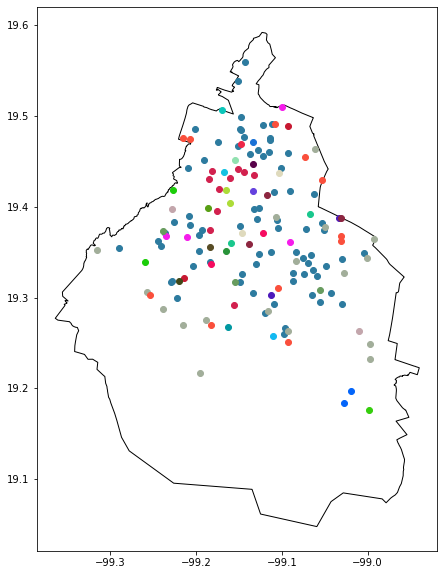

In [28]:
_,k = data_subset.shape

X = data_subset.iloc[:,3:k].copy().values

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

# colors = ['red','blue','green']
# clustering = KMeans(n_clusters=3, random_state=12345).fit(X_scaled)
clustering = MeanShift(bandwidth=.5).fit(X_scaled)

number_of_colors = len(clustering.labels_)
colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

for p in np.unique(clustering.labels_):
    print(f'Proporción cluster {colors[p]}')
    print(np.round(100*(clustering.labels_==p).mean(),2))
    
base = shp_ent.plot(color='white', edgecolor='black',figsize=[10,10])
for p,c in zip(np.unique(clustering.labels_),colors):
    pts = [Point(lon,lat) for lon,lat in zip(data_subset.loc[clustering.labels_==p,'longitud'],data_subset.loc[clustering.labels_==p,'latitud'])]
    points = gpd.GeoDataFrame({'geometry':pts})
    points = points.set_crs("EPSG:4326")
    points.plot(ax=base,c=c)

In [26]:
for p in np.unique(clustering.labels_):
    print(f'-------------- CLUSTER {colors[p]} --------------')
    print(data_subset.iloc[clustering.labels_==p,3:k].describe().T[['min','50%','max']])

-------------- CLUSTER #50FB97 --------------
                                     min         50%         max
bancos_numero                   0.000000    3.218876    5.105945
bancos_distancia                3.932414    5.757608    7.286020
secundarias_privadas_distancia  4.531308    7.137771    8.258902
supermercados_numero            0.000000    1.098612    1.945910
supermercados_distancia         4.172077    6.371082    7.639570
hospitales_privados_distancia   4.912655    7.189681    8.281365
cines_distancia                 4.530554    7.290763    8.497955
restaurantes_numero             1.609438    3.135494    4.634729
restaurantes_distancia          3.642312    5.251645    6.782351
cafeterias_distancia            3.520757    5.090924    6.431041
hoteles_distancia               4.232075    6.944251    8.537345
pobtot                          0.000000  122.000000  429.000000
hogjef_f                        0.000000   10.000000   34.000000
tothog                          0.000000   3

In [12]:
map = folium.Map(location=[19.400962,-99.139016], zoom_start=12)
colors = ['red','blue','green']
for p,c in zip(np.unique(clustering.labels_),colors):
    longitudes = data_subset.loc[clustering.labels_==p,'longitud'].to_list()
    latitudes = data_subset.loc[clustering.labels_==p,'latitud'].to_list()
    for i in range(0, len(longitudes)):
        folium.Marker([latitudes[i],longitudes[i]],
                      icon=folium.Icon(color=c)).add_to(map)
map